In [1]:
import timeit

import numpy as np
import matplotlib.pyplot as plt

from scripts.queso_model import model_vars, model_data, objective_func, balance, alloc_df
# Ejecutar esta línea si pymoo no ha sido instalado
# %pip install -U pymoo

# Algoritmo Genético
Utilizando la librería [pymoo](https://pymoo.org/index.html), redefiniendo los operadores para cumplir con las restricciones del modelo de optimización.

## Parámetros

In [2]:
# Escenario 1
folder = './data/test1/' # Carpeta con los datos
info_acopios = 'nuevo_info_acopios.xlsx' # Datos de centros de acopio 
costo_transporte = 'costoTransporteCAi.xlsx' # Matriz de costos de transporte entre CAs 
tiempo_transporte = 'tiempoTransporteCAi.xlsx' # Matriz de tiempos de transporte entre CAs
demanda = 60 # Demanda del cliente
ctiempo = 100 # Costo por unidad de tiempo

# Escenario 2
# folder = './data/test2/'
# info_acopios = 'centros_acopio.xlsx'
# costo_transporte = 'costo_transporte.xlsx'
# tiempo_transporte = 'tiempos_transporte.xlsx'
# demanda = 4000
# ctiempo = 100

# Escenario 3
# folder = './data/test3/'
# info_acopios = 'info_acopios_escenario3.xlsx'
# costo_transporte = 'costo_transporte_escenario3.xlsx'
# tiempo_transporte = 'tiempos_transporte_escenario3.xlsx'
# demanda = 60
# ctiempo = 1000

# Probabilidad de cruce
p_cross = 0.55
# Probabilidad de mutación
p_mutate = 0.8
# Tamaño de la población
pop_size = 100
# Número de iteraciones antes de finalizar 
# al no encontrar una mejor solución
period = 100
# Máximo número de generaciones
max_gen = 1000
# Máximo de evaluaciones de función objetivo
max_evals = 100000

In [3]:
archivos = {
    'info_acopios': info_acopios,
    'costo_transporte' : costo_transporte,
    'tiempo_transporte' : tiempo_transporte,
}

data = model_data(archivos, demanda, ctiempo, folder=folder)

demanda = data['demanda']
ctiempo = data['ctiempo']
# t_max = data['t_max']
params_df = data['params_df']

N, seed, capacidades = model_vars(params_df)

## Definición 
Del modelo de optimización

In [4]:
from pymoo.core.problem import ElementwiseProblem

xl = np.zeros(capacidades.shape[0])
xu = capacidades


class Queso(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=len(xl),
            n_obj=1,
            n_eq_constr=1,
            xl=xl,
            xu=xu
        )

    def _evaluate(self, x, out, *args, **kwargs):
        out['F'] = objective_func(x, N, data)
        # Se retira el último elemento del vector (centro de acopio principal), 
        # para validar la restricción de igualdad
        individual = np.delete(x, N * 2)
        out['H'] = demanda - np.sum(individual)


model = Queso()

## Generación 
De nuevas posibles soluciones

In [5]:
from pymoo.core.sampling import Sampling


class TopOrZeroSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        gen_matrix = np.zeros((n_samples, problem.n_var), dtype=float)
        # Se indexan los centros de acopio
        n_vars = problem.n_var

        for i in range(n_samples):
            # Se reorganizan todos los índices de los centros de acopio, de forma aleatoria
            indices = np.arange(n_vars - 1)
            np.random.shuffle(indices)

            while np.sum(gen_matrix[i]) < demanda and indices.size > 0:
                idx = indices[0]
                gen_matrix[i, idx] += capacidades[idx]
                indices = np.delete(indices, 0)

                if np.sum(gen_matrix[i]) > demanda:
                    gen_matrix[i, idx] = gen_matrix[i, idx] - (np.sum(gen_matrix[i]) - demanda)
                    break

            gen_matrix[i, N * 2] = np.random.randint(capacidades[N * 2] + 1)

        return gen_matrix

## Cruce

Implementación de cruce en un punto

In [6]:
from pymoo.core.crossover import Crossover

class SinglePointCross(Crossover):
    def __init__(self, prob):
        # Para la implementación personalizada de este método, se consideraron 2 padres,
        # entonces cambiar los valores de la llamada a init no tendrá efecto.
        # Lo mismo pasa con el único offspring.
        super().__init__(n_parents=2, n_offsprings=1, prob=prob)

    def _do(self, problem, X, **kwargs):
        # n_parents, n_matings, n_var
        _, n_matings, n_var = X.shape

        T = np.zeros((1, n_matings, n_var))
        Y = np.full_like(T, None, dtype=float)

        for idx in range(n_matings):

            # Primera mitad
            p1 = X[0, idx, : n_var//2]
            # Segunda mitad
            p2 = X[1, idx, n_var//2 : n_var - 1]

            offspring = np.concatenate((p1, p2))

            if np.sum(offspring) > demanda:
                delta = np.sum(offspring) - demanda
                balance(offspring, capacidades, delta, True)
            else:
                delta = demanda - np.sum(offspring)
                balance(offspring, capacidades, delta, False)

            for i in range(offspring.shape[0]):
                Y[0, idx, i] = offspring[i]

            # Centro de acopio principal (última posición)
            main = np.random.choice([X[0, idx, n_var-1], X[1, idx, n_var-1]])
            Y[0, idx, n_var-1] = main

        return Y

## Mutación
Con una probabilidad dada, reasignar la cantidad asignada a un centro de acopio **o**, reasignar el centro de acopio principal.

In [7]:
from pymoo.core.mutation import Mutation

class ReassignMutation(Mutation):
    def __init__(self, prob):
        super().__init__()
        self.prob = prob

    def _do(self, problem, X, **kwargs):
        for i in range(len(X)):
            r = np.random.random()

            if r < self.prob:
                # Se toma un índice aleatorio
                individual = X[i]
                idx_mut = np.random.randint(individual.shape)

                # Si es el índice del centro de acopio principal (N*2)
                if idx_mut == N*2:
                    X[i, problem.n_var-1] = np.random.randint(capacidades[N * 2] + 1)

                else:
                    if individual[idx_mut] == 0:
                        # Se asigna la máxima cantidad posible del índice
                        delta = capacidades[idx_mut]
                        individual[idx_mut] = capacidades[idx_mut]
                        diff = True
                    else:
                        # Se asigna cero a la cantidad del índice
                        delta = individual[idx_mut]
                        individual[idx_mut] = 0
                        diff = False

                    balance(individual, capacidades, delta, diff)

                    for j in range(individual.shape[0]):
                        X[i, j] = individual[j]

        return X

## Aplicación

Definición del algoritmo genético


In [8]:
from pymoo.algorithms.soo.nonconvex.ga import GA

algorithm = GA(
    pop_size=pop_size,
    sampling=TopOrZeroSampling(),
    crossover=SinglePointCross(prob=p_cross),
    mutation=ReassignMutation(prob=p_mutate),
    eliminate_duplicates=True
)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



Criterio de terminación: https://pymoo.org/interface/termination.html

In [9]:
from pymoo.termination.default import DefaultSingleObjectiveTermination

termination = DefaultSingleObjectiveTermination(
    # Definición de tolerancia para lo que se 
    # considera una solución diferente
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=period, 
    n_max_gen=max_gen,
    n_max_evals=max_evals
)

Optimización y resultados

In [10]:
from pymoo.optimize import minimize

t_start_ga = timeit.default_timer()
ga = minimize(model, algorithm, termination, seed=seed, save_history=True, verbose=False)
t_end_ga = timeit.default_timer()

t_delta_ga = t_end_ga - t_start_ga

In [11]:
# print(f'Centro de acopio principal: {params_df['Id_CA'].iloc[int(ga.X[N * 2])]}')
print(f'Precio: {np.squeeze(ga.F)}')
print(f'Tiempo: {round(t_delta_ga * 1000)}ms, ({t_delta_ga}s)')

Precio: 392608.0
Tiempo: 14816ms, (14.816473899991252s)


In [12]:
asignaciones = alloc_df(ga.X, params_df, N, capacidades)
asignaciones

,CAcopio,C.Stock,Stock,C.Potencial,Potencial
0,CA1,10.0,10.000,0.500,0.500
1,CA2,12.0,12.000,0.625,0.625
2,CA3,4.0,0.000,14.000,0.000
3,CA4,8.0,8.000,13.000,13.000
4,CA5,18.0,0.000,15.000,0.000
5,CA6,6.0,0.000,14.000,0.000
6,CA7,12.0,1.375,13.000,0.000
7,CA8,2.0,2.000,12.500,12.500
8,CA9,30.0,0.000,15.000,0.000
9,CA10,15.0,0.000,18.000,0.000


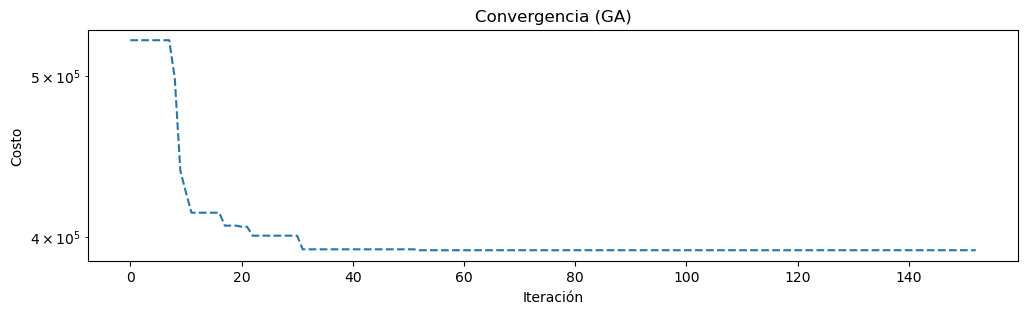

In [13]:
n_evals = np.array([e.evaluator.n_eval for e in ga.history])
opt = np.array([e.opt[0].F for e in ga.history])
gen_evals = np.arange(opt.shape[0])

plt.figure(figsize=(12,3))
plt.title('Convergencia (GA)')
plt.xlabel('Iteración')
plt.ylabel('Costo')
plt.plot(gen_evals, opt, '--')
plt.yscale('log')
plt.show()

## Resultados

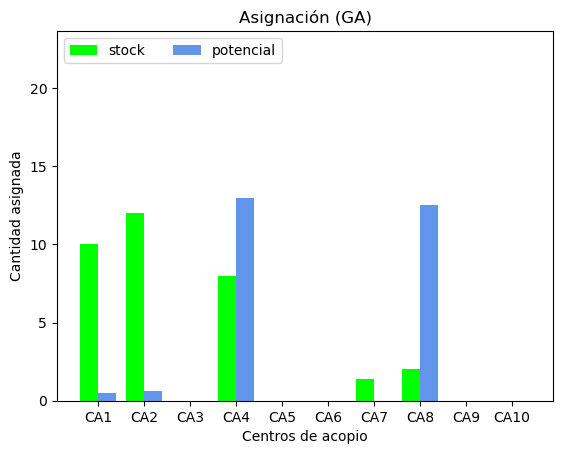

In [14]:
even = np.arange(0, N*2-1, 2)
odd = np.arange(1, N*2, 2)

cap_stock = np.take(capacidades, even)
cap_potencial = np.take(capacidades, odd)

ca_stock = np.take(ga.X, even)
ca_potencial = np.take(ga.X, odd)

labels = params_df['Id_CA']
x = np.arange(len(labels))
y1 = ca_stock
y2 = ca_potencial

fig, ax = plt.subplots()
y_lim = np.array(np.mean([np.max(capacidades), np.max(ga.X)])) * 1.1
ax.set_ylim([0, y_lim])
x1_bar = ax.bar(x-0.2, y1, width=0.4, label='stock', color='lime')
x2_bar = ax.bar(x+0.2, y2, width=0.4, label='potencial', color='cornflowerblue')

plt.xticks(x, labels)
plt.title('Asignación (GA)')
plt.xlabel('Centros de acopio')
plt.ylabel('Cantidad asignada')
plt.legend(loc='upper left', ncol=2)
plt.show()

In [15]:
ca_stock_norm = ca_stock / cap_stock
ca_potencial_norm = ca_potencial / cap_potencial

ca_norm = ca_stock_norm.tolist()
for i,v in enumerate(ca_potencial_norm):
    ca_norm.insert(2 * i + 1, v)
ca_norm.append(0)
ca_norm = np.round(ca_norm, 3)
ca_norm = ca_norm * 100 

ca_norm_df = alloc_df(ca_norm, params_df, N, capacidades, '% Stock', '% Potencial')
ca_norm_df

,CAcopio,C.Stock,% Stock,C.Potencial,% Potencial
0,CA1,10.0,100.0,0.500,100.0
1,CA2,12.0,100.0,0.625,100.0
2,CA3,4.0,0.0,14.000,0.0
3,CA4,8.0,100.0,13.000,100.0
4,CA5,18.0,0.0,15.000,0.0
5,CA6,6.0,0.0,14.000,0.0
6,CA7,12.0,11.5,13.000,0.0
7,CA8,2.0,100.0,12.500,100.0
8,CA9,30.0,0.0,15.000,0.0
9,CA10,15.0,0.0,18.000,0.0


In [16]:
# # Prueba con n iteraciones
# def ga_test(n):
#     hist = []
#     hist_t = []
# 
#     for i in range(n):
# 
#         t_i = timeit.default_timer()
#         ga_opt = minimize(model, algorithm, termination, seed=seed, save_history=False, verbose=False)
#         t_f = timeit.default_timer()
# 
#         t_delta = t_f - t_i
#         hist.append(ga_opt.F)
#         hist_t.append(t_delta)
# 
#     return hist, hist_t, n
# 
# history, hist_time, times = ga_test(10)
# print(history, '\n', hist_time, '\n', times)